In [20]:
import pandas as pd
import numpy as np
from scipy.linalg import fractional_matrix_power
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

training_data = pd.read_csv('TrainingRidge.csv', delimiter=",", header=0)
validation_data = pd.read_csv('ValidationRidge.csv', delimiter=",", header=0)

training_data = training_data.sample(frac=1)
validation_data = validation_data.sample(frac=1)

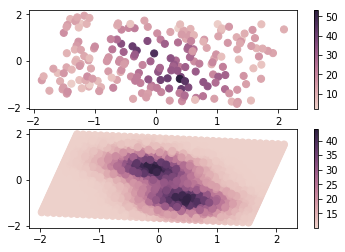

In [21]:
#### a)

X = training_data[["x1", "x2"]]
X_val = validation_data[["x1", "x2"]]
#X.plot.scatter(x="x1", y="x2")

# Center
X_c = (X - np.mean(X)).T
X_c_val = (X_val - np.mean(X)).T
#X_c.T.plot.scatter(x="x1", y="x2")

# Rotate
C = 1/200 * X_c.dot(X_c.T)
eigenvalues, eigenvectors = np.linalg.eigh(C)
X_r = eigenvectors.dot(X_c)
X_r_val = eigenvectors.dot(X_c_val)
#(pd.DataFrame(X_r.T, columns=["x1", "x2"])).plot.scatter(x="x1", y="x2")

# Normalize
Lambda = np.identity(np.size(eigenvalues)) * eigenvalues
X_w = fractional_matrix_power(Lambda, -0.5).dot(X_r)
X_w_val = fractional_matrix_power(Lambda, -0.5).dot(X_r_val)
X_w = pd.DataFrame(X_w.T, columns=["x1", "x2"])
X_w_val = pd.DataFrame(X_w_val.T, columns=["x1", "x2"])


# Plot
f = plt.figure()
ax = plt.subplot(211)
cmap = sns.cubehelix_palette(as_cmap=True)
points = ax.scatter(X_w.values[:,0], X_w.values[:,1], c=training_data["obs"], s=50, cmap=cmap)
f.colorbar(points)
ax = plt.subplot(212)
points = ax.scatter(X_w_val.values[:,0], X_w_val.values[:,1], c=validation_data["dens"], s=50, cmap=cmap)
f.colorbar(points)

Generated 55 Monomials
Generated 10 Monomials


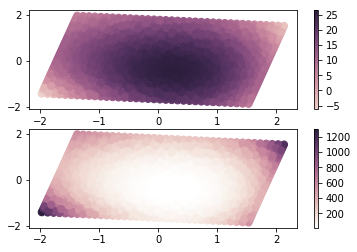

In [22]:
##### b)
def monomial(x1, x2, K):
    i=0
    phi_train = pd.DataFrame()
    for k in range(0,K+1):
        for l in range(0,k+1):
            m = k-l
            i += 1
            phi_train["phi"+str(i)] = x1 ** l * x2 ** m
    print("Generated "+str(i)+" Monomials")
    return phi_train

def plotW(w):
    cmap = sns.cubehelix_palette(as_cmap=True)
    f = plt.figure()
    ax = plt.subplot(211)
    y_pred = w.T.dot(phi_val.T) 
    y_diff = (y_pred - validation_data[["dens"]].values) **2
    
    points = ax.scatter(X_w_val.values[:,0], X_w_val.values[:,1], c=y_pred[0,:], s=50, cmap=cmap)
    f.colorbar(points)
    
    ax = plt.subplot(212)
    color_palette=sns.cubehelix_palette(light=1, as_cmap=True)
    points = ax.scatter(X_w_val.values[:,0], X_w_val.values[:,1], c=y_diff[0,:], s=50, cmap=color_palette)
    f.colorbar(points)
    
phi = monomial(X_w["x1"], X_w["x2"], 9)

phi_val = monomial(X_w_val["x1"], X_w_val["x2"], 3)
w_val = np.linalg.inv(phi_val.T.dot(phi_val)).dot(phi_val.T).dot(validation_data[["dens"]].values)

plotW(w_val)

Generated 55 Monomials
lambda_t=10.0


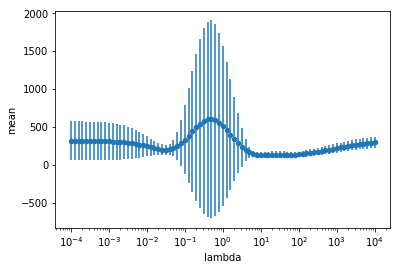

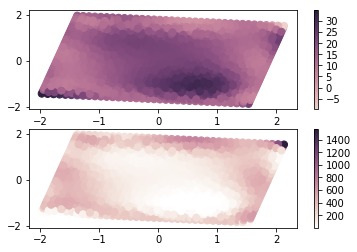

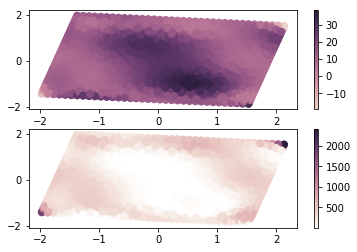

In [26]:
######## c)
def calculateW(X, Y, _lambda):
    inverse = np.linalg.inv(X.dot(X.T) + _lambda * np.identity(X.shape[0]))
    w = inverse.dot(X).dot(Y)
    return w
    
def calculateMSE(w, test_X, test_Y):
    predictions = w.T.dot(test_X).T[:,0]
    return np.mean(((test_Y - predictions) ** 2).T)

def n_fold(X, Y):
    means = np.array([])
    stds = np.array([])
    lambdas = np.array([])
    
    X_parts = np.array_split(X, 10)
    Y_parts = np.array_split(Y, 10)
    
    for z in np.arange(-4, 4.1, 0.1): #range(-4, -4, 0.1):
        l =  10 ** z
        #print("Lambda="+str(l))
        MSEs = np.array([])
        for ifold in range(0, 10):
            phi_te = X_parts[ifold].T
            phi_tr = pd.concat(X_parts[:ifold]+X_parts[ifold+1:]).T

            val_te = Y_parts[ifold]
            val_tr = np.concatenate(Y_parts[:ifold]+Y_parts[ifold+1:])
            
            w = calculateW(phi_tr, val_tr, l)
            MSE = calculateMSE(w, phi_te, val_te)
            MSEs = np.append(MSEs, MSE)
            
        lambdas = np.append(lambdas, l)
        stds = np.append(stds, MSEs.std())
        means = np.append(means, MSEs.mean())

    folding_df = pd.DataFrame(np.array([lambdas, means, stds]).T, columns=["lambda", "mean", "std"])
    #fig, ax = plt.subplots()
    folding_df.plot.scatter(x="lambda", y="mean", yerr="std", logx=True)
    #print(folding_df)
    return folding_df

y = training_data[["obs"]].values
folding_df = n_fold(phi, y)
phi_val = monomial(X_w_val["x1"], X_w_val["x2"], 9)

# Plot the lowest mean
lambda_t = folding_df.iloc[folding_df['mean'].idxmin()]["lambda"]
w_t = calculateW(phi.T, y, lambda_t)
plotW(w_t)
print("lambda_t="+str(lambda_t))

# Plot the highest std (This isnt in the task but I was interested to see what something overfitted would look like)
lambda_overfitted = folding_df.iloc[folding_df['std'].idxmax()]["lambda"]
w_t = calculateW(phi.T, y, lambda_overfitted)
plotW(w_t)


lambda_g=251.188643151
Compare MSEs on training set
Error on training set for lambda_t = 160.516410387
Error on training set for lambda_g = 116.461682
Compare MSEs on validation set
Error on validation set for lambda_t = 149.905356177
Error on validation set for lambda_g = 100.116304006


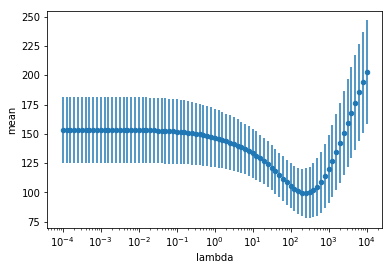

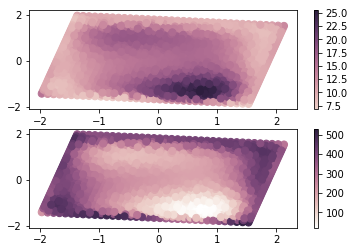

In [25]:
######### d)
folding_df_val = n_fold(phi_val, validation_data[["dens"]].values)
lambda_g = folding_df_val.iloc[folding_df_val['mean'].idxmin()]["lambda"]
w_g = calculateW(phi_val.T, validation_data[["dens"]].values, lambda_g)
plotW(w_g)
print("lambda_g="+str(lambda_g))

print("Compare MSEs on training set")
E_train_t = calculateMSE(w_t, phi.T, y)
E_train_g = calculateMSE(w_g, phi.T, y)
print("Error on training set for lambda_t = "+str(E_train_t))
print("Error on training set for lambda_g = "+str(E_train_g))



print("Compare MSEs on validation set")
E_val_t = calculateMSE(w_t, phi_val.T, validation_data[["dens"]].values)
E_val_g = calculateMSE(w_g, phi_val.T, validation_data[["dens"]].values)
print("Error on validation set for lambda_t = "+str(E_val_t))
print("Error on validation set for lambda_g = "+str(E_val_g))